In [619]:
import tensorflow as tf
import gym
import scipy.signal
import os
import time
import inspect
from multiprocessing import Process
import tensorflow.contrib.distributions as ds
from sklearn.utils import shuffle
from math import pi
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['image.cmap'] = 'gray_r'

In [620]:
%%capture
# download MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

In [621]:
sess = tf.InteractiveSession()

## Utility Functions

In [622]:
def print_single_digit(img):
    if len(img.shape) == 3:
        img = np.squeeze(img)
    plt.imshow(img)
    plt.show()

def print_multiple_digits(imgs, n):
    for i in range(n):
        print_single_digit(imgs[i])

## Constants

In [623]:
BATCH_SIZE = 100
# height and width of input images
IMG_SIZE = 28

NUM_GLIMPSES = 10
# height and width of each glimpse
GLIMPSE_SIZE = 10
# coordinates for center of each glimpse
# tf.image coordinate system is weird
# axes are rotated 90 degrees clockwise
# so (-1, -1) in tf.image coordinates is top left
GLIMPSE_CENTER = [1, 0]
# number of resolutions per glimpse
NUM_RESOLUTIONS = 10

## Load and Visualize MNIST

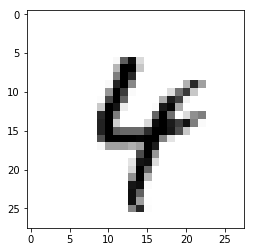

In [624]:
# load training data, labels
imgs, labels = mnist.train.next_batch(BATCH_SIZE)
# convert flattened images into 2D arrays
imgs = imgs.reshape([BATCH_SIZE, IMG_SIZE, IMG_SIZE])
# sanity check
print_multiple_digits(imgs, 1)

## Extract Glimpse at One Resolution

In [625]:
center = np.array([GLIMPSE_CENTER])

# use same center for each glimpse
centers = np.repeat(center, NUM_GLIMPSES, axis=0)
# add a dimension for number of channels
# this is needed by tf.image.extract_glimpse()
first_ten_imgs = np.expand_dims(imgs[:NUM_GLIMPSES], 3)

glimpses_tensor = tf.image.extract_glimpse(input=first_ten_imgs, 
                                           size=[GLIMPSE_SIZE, GLIMPSE_SIZE], 
                                           offsets=centers,
                                           uniform_noise=False)

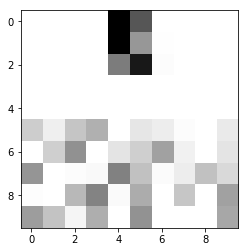

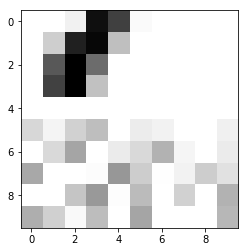

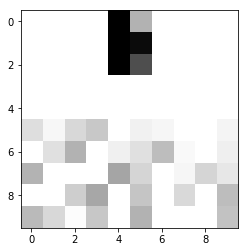

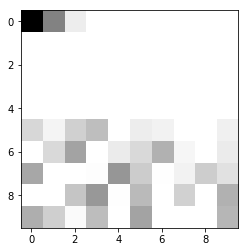

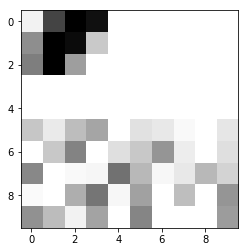

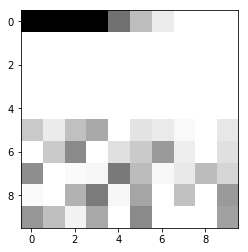

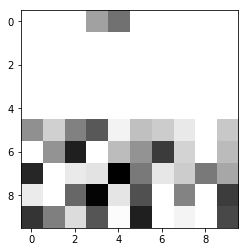

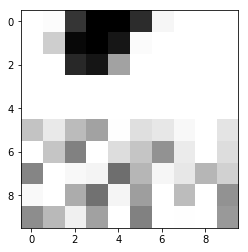

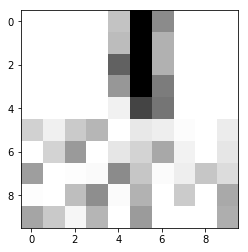

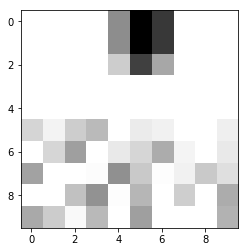

In [626]:
# convert tensor of glimpses to array
glimpses = tf.squeeze(glimpses_tensor).eval()
# print out the glimpses
print_multiple_digits(glimpses, 10)

Glimpse is centered at: [1, 0] (tf coordinates)


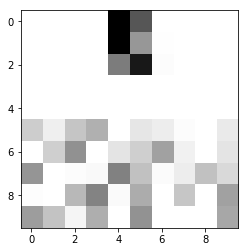

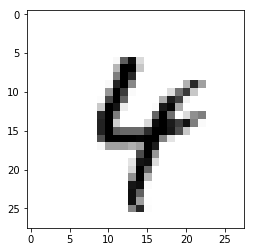

In [627]:
# compare 1st glimpse to original image
print("Glimpse is centered at: {} (tf coordinates)".format(GLIMPSE_CENTER))
print_single_digit(glimpses[0])
print_single_digit(imgs[0])

## Extract Glimpses at Multiple Resolutions

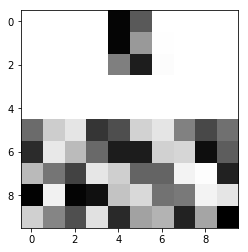

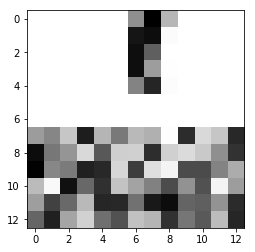

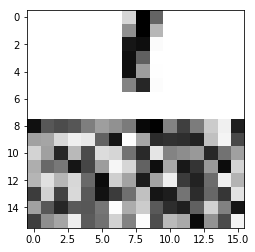

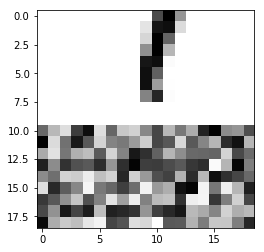

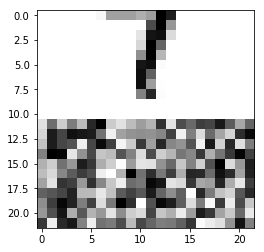

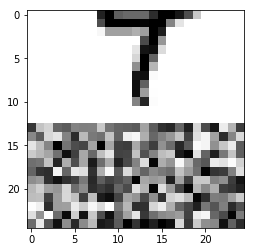

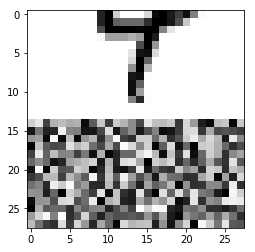

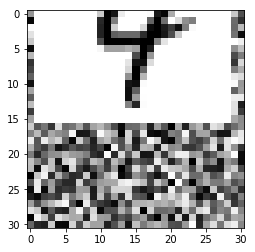

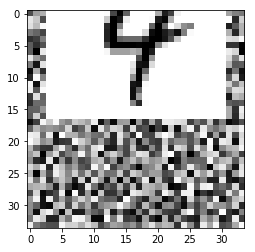

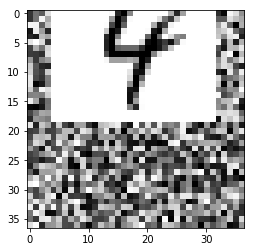

In [628]:
first_img = np.expand_dims(first_ten_imgs[0], 0)
all_resolutions = []
all_resolutions_reshaped = []
center = np.array([centers[0]])
for i in range(NUM_RESOLUTIONS):
    g = tf.image.extract_glimpse(input=first_img,
                                 size=[GLIMPSE_SIZE + i*3, GLIMPSE_SIZE + i*3], 
                                 offsets=center)
    all_resolutions.append(g)
    all_resolutions_reshaped.append(np.squeeze(g.eval()))
    
print_multiple_digits(all_resolutions_reshaped, len(all_resolutions))


In [629]:
def resize(img_tensor):
    a = tf.image.resize_images(img_tensor, size=[GLIMPSE_SIZE, GLIMPSE_SIZE])
    print_single_digit(np.squeeze(a.eval()))


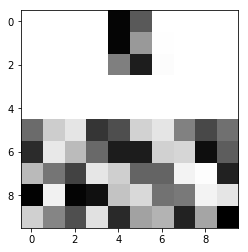

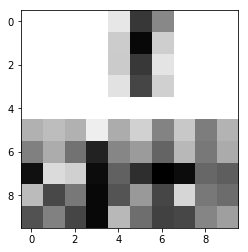

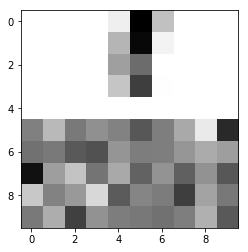

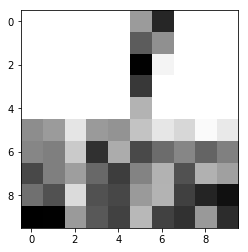

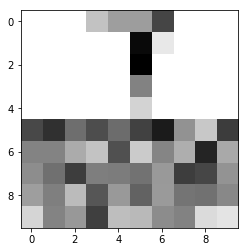

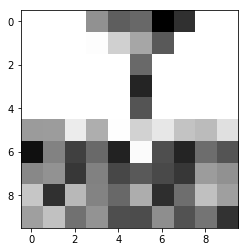

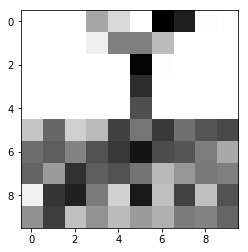

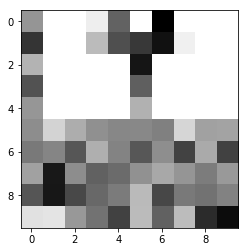

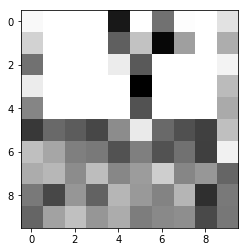

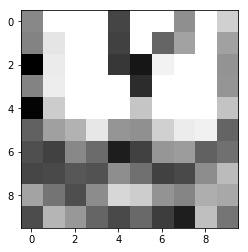

In [630]:
for img in all_resolutions:
    resize(img)

## `tf.image.resize_area()` vs. `tf.image.resize_images()`

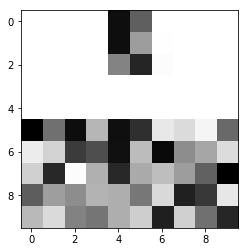

In [631]:
print_single_digit(np.squeeze(tf.image.resize_area(all_resolutions[0], [10, 10]).eval()))

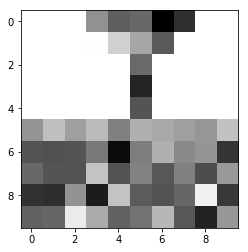

In [632]:
print_single_digit(np.squeeze(tf.image.resize_images(all_resolutions[5], [10, 10]).eval()))

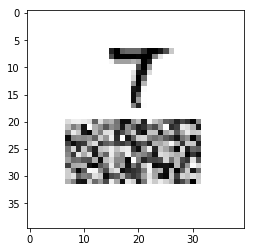

In [633]:
print_single_digit(np.squeeze(tf.image.resize_image_with_crop_or_pad(all_resolutions[5], 40, 40).eval()))

## Resizing Image w/o Noise

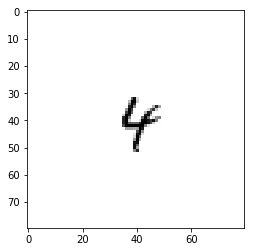

In [634]:
first_img = np.expand_dims(imgs[0], 0)
first_img = np.expand_dims(first_img, 3)
print_single_digit(np.squeeze(tf.image.resize_image_with_crop_or_pad(first_img, 80, 80).eval()))

In [635]:
b = np.array([
            [0.5, 0.5, 1, 1],
            [0.3, 0.3, 1, 1],
            [0.15, 0.15, 1, 1],
            [-.10, -.10, 1, 1]
            ])

img = np.expand_dims(imgs[:2].reshape([2, IMG_SIZE, IMG_SIZE]), 3)
t = tf.image.crop_and_resize(img,
    b,
    [0,0,0,0],
    [10,10],
    method=None,
    extrapolation_value=0.0,
    name=None
)

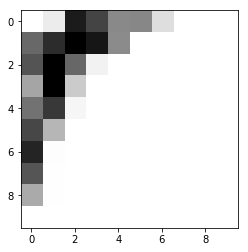

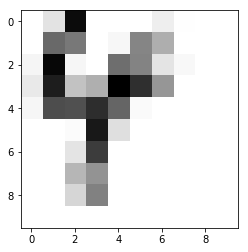

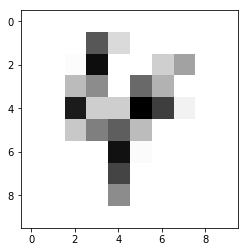

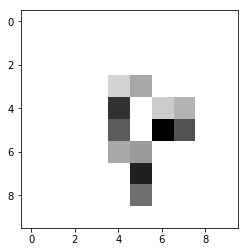

In [636]:
print_multiple_digits(np.squeeze(t.eval()), 4)

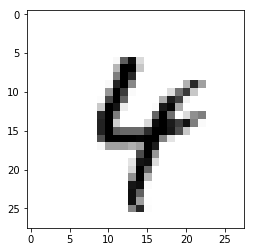

In [637]:
print_single_digit(imgs[0])

## Take glimpses using `tf.image.crop_and_resize()`

In [638]:
# number of glimpses per image
NUM_GLIMPSES = 6
# height, width to which glimpses get resized
GLIMPSE_SIZE = 12
# number of resolutions per glimpse
NUM_RESOLUTIONS = 4
# number of training epochs
# NUM_EPOCHS = 
# batch size for each training iterations
# total training iterations = num_epochs * number of images / batch_size
BATCH_SIZE = 10
# for normalization purposes
EPSILON = 1e-10

# size of images
IMG_SIZE = 28
# number of classes for classificatino
NUM_CLASSES = 10
NUM_CHANNELS = 1


def get_glimpses(data, loc):
    box_bounds = [
        [0.5, 0.5, 1, 1],
        [0.3, 0.3, 1, 1],
        [0.15, 0.15, 1, 1],
        [-.10, -.10, 1, 1]
    ]

    num_data_points = len(data)
    boxes = box_bounds * num_data_points
    box_ind = np.arange(num_data_points).repeat(NUM_RESOLUTIONS)
    crop_size = [GLIMPSE_SIZE, GLIMPSE_SIZE]
    method = "bilinear"
    extrapolation_value = 0.0
    
    data = np.expand_dims(data.reshape([num_data_points, IMG_SIZE, IMG_SIZE]), 3)

    glimpses = tf.image.crop_and_resize(data,
                            boxes=boxes,
                            box_ind=box_ind,
                            crop_size=crop_size,
                            method=method,
                            extrapolation_value=extrapolation_value)

    print_multiple_digits(glimpses.eval(), 20)
    # flatten each image into a vector
    return tf.reshape(tf.squeeze(glimpses), [num_data_points * NUM_RESOLUTIONS, GLIMPSE_SIZE * GLIMPSE_SIZE])


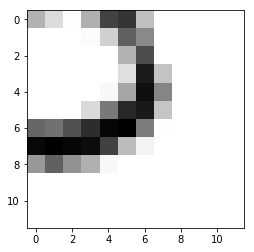

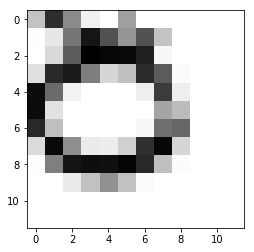

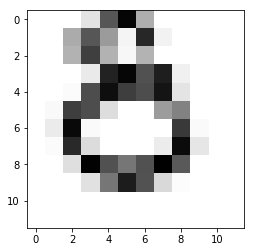

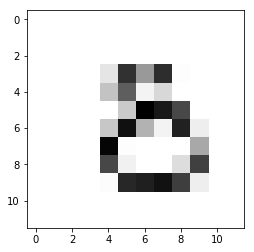

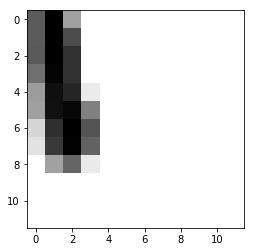

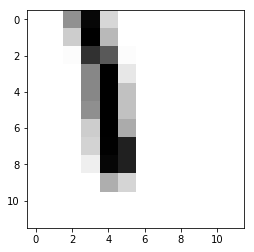

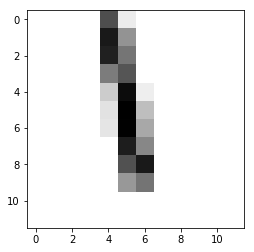

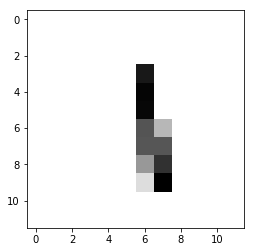

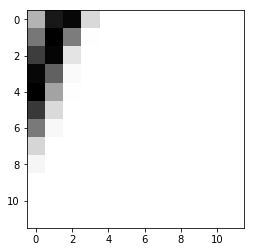

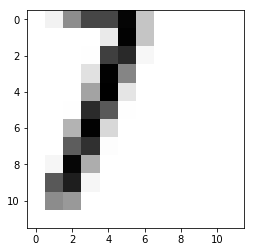

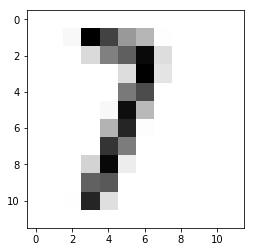

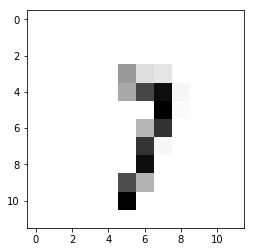

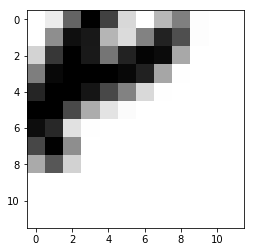

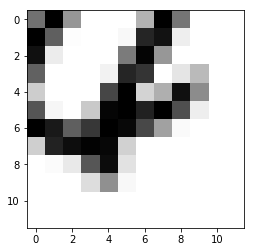

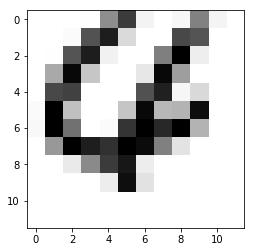

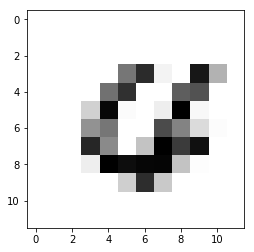

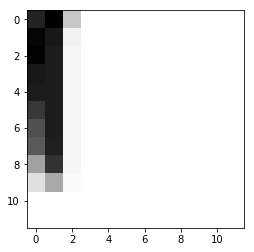

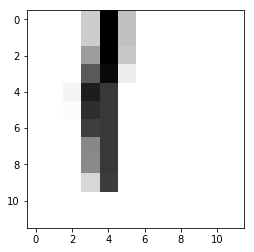

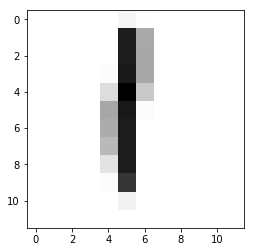

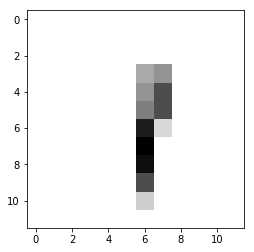

In [639]:
g = get_glimpses(mnist.train.next_batch(BATCH_SIZE)[0], [0,0])